### 1. Install Required Libraries


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

 ### 2. Load the Data

In [ ]:
df = pd.read_csv('D:\\Vcodez\\Anomaly detection in IOT sensors using VAE\\Datasets\\iot_sensor_data_with_anomalies.csv')

### 3. EDA

In [8]:
df.head()

,Temperature,Humidity,Light,CO2,Noise,Motion,Pressure,Vibration,Label
0,22.943930,37.972544,320.770136,369.176710,34.623648,0,1017.801180,0.001908,0
1,25.528221,41.582345,242.702123,396.740041,38.784371,1,997.857035,0.002242,0
2,23.273449,42.298026,305.897605,367.514093,34.860739,1,1011.023377,0.002110,0
3,23.632640,40.546611,288.156662,384.868835,35.308937,1,1011.514510,0.001709,0
4,25.953549,38.199329,345.119789,435.488550,34.974689,1,1008.095827,0.001483,0


In [15]:
df.shape

(1050, 9)

In [10]:
null_values = df.isnull().sum()
null_values

Temperature    0
Humidity       0
Light          0
CO2            0
Noise          0
Motion         0
Pressure       0
Vibration      0
Label          0
dtype: int64

In [17]:
print(df['Label'].value_counts())

Label
0    1000
1      50
Name: count, dtype: int64


In [12]:
df.describe()

,Temperature,Humidity,Light,CO2,Noise,Motion,Pressure,Vibration,Label
count,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,25.236194,41.903716,315.007043,424.702465,37.182845,0.529524,1006.716982,0.003342,0.047619
std,5.639764,8.841232,67.955090,106.987881,9.812009,0.499365,24.183860,0.006177,0.213060
min,20.571140,34.206426,233.917917,343.550722,28.630888,0.000000,878.344757,0.000058,0.000000
25%,23.357697,38.782736,288.477286,391.445424,33.765481,0.000000,1008.014660,0.001672,0.000000
50%,24.048917,40.153963,301.446237,402.770237,35.225889,1.000000,1011.741534,0.002022,0.000000
75%,24.822660,41.557948,315.750146,412.934713,36.594686,1.000000,1015.336874,0.002384,0.000000
max,55.384552,92.517081,699.029370,935.708366,89.725833,1.000000,1027.718203,0.042645,1.000000


### 4. Preprocessing

In [ ]:
# Drop timestamp and label for training
X = df.drop(columns=["Label"])
y = df["Label"]  # Save the true labels

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use only normal data (Label = 0) to train the VAE
X_normal = X_scaled[y == 0]

# Split into training and validation sets
X_train, X_val = train_test_split(X_normal, test_size=0.1, random_state=42)


### 5. Build the VAE Model

In [3]:

input_dim = X_train.shape[1]
latent_dim = 2

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(32, activation='relu')(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(latent_inputs)
decoder_outputs = layers.Dense(input_dim)(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }


vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=lambda y_true, y_pred: 0.0)

### 6. Train the Model

In [ ]:
vae.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val))

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - kl_loss: 0.0831 - loss: 0.3121 - reconstruction_loss: 0.2290 - val_loss: 0.0000e+00
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 0.0204 - loss: 0.2088 - reconstruction_loss: 0.1884 - val_loss: 0.0000e+00
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.0104 - loss: 0.1848 - reconstruction_loss: 0.1744 - val_loss: 0.0000e+00
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 0.0079 - loss: 0.1781 - reconstruction_loss: 0.1702 - val_loss: 0.0000e+00
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 0.0060 - loss: 0.1728 - reconstruction_loss: 0.1668 - val_loss: 0.0000e+00
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - kl_loss: 0.0046 - loss: 0.1694 - reconstruction_loss: 0.1648 - val_loss: 0.0000e+00
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.0036 - loss: 0.1688 - reconstruction_loss: 0.1652 - val_loss: 0.0000e+00
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/s

### 7. Detect Anomalies Using Reconstruction Error

In [ ]:
# Reconstruct all data
X_pred = vae.predict(X_scaled)
reconstruction_error = tf.keras.losses.mse(X_scaled, X_pred).numpy()

# Set a threshold for anomaly detection
threshold = reconstruction_error[y == 0].mean() + 2 * reconstruction_error[y == 0].std()
print("Anomaly threshold:", threshold)

# Predict anomalies
y_pred = [1 if err > threshold else 0 for err in reconstruction_error]

# Accuracy
print(classification_report(y, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Anomaly threshold: 0.21418508514761925
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1000
           1       0.55      1.00      0.71        50

    accuracy                           0.96      1050
   macro avg       0.77      0.98      0.84      1050
weighted avg       0.98      0.96      0.97      1050



### 8. Visualizing Errors the of anomoly Data

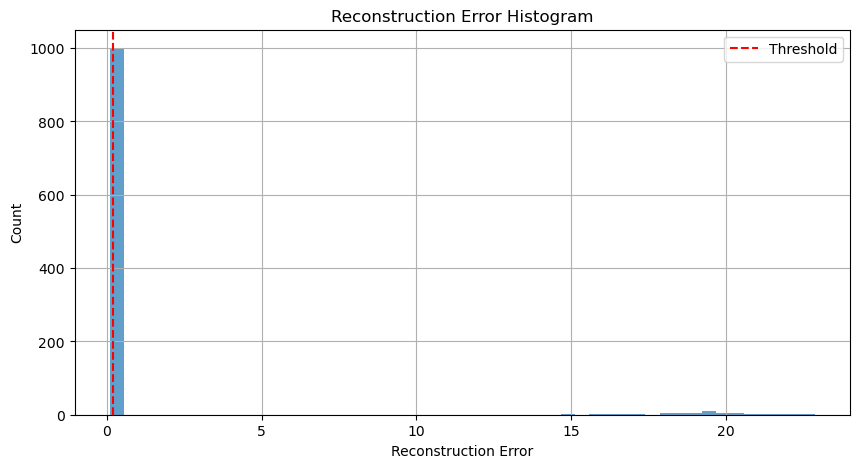

In [ ]:
#Anomaly threshold: 0.21418508514761925
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error, bins=50, alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Histogram")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()
